# Previsão de renda

### 4 elementos importantes
- Esse notebook
- Streamlit com as análises
- Seu Github com o projeto
- Vídeo no readme do github mostrando o streamlit

## Etapa 1 CRISP - DM: Entendimento do negócio

<span style="color:red">A análise para a concessão de cartões de crédito é um assunto de extrema importância no setor financeiro. Para que o limite de crédito seja liberado, o banco ou algum outro tipo de industria financeira, utilizam informações pessoais e dados fornecidos pelos candidato para prever a probabilidade de inadimplência futura e comportamento de endividamento com o cartão.</span>

<span style="color:red">Vamos utlizar desses dados fornecidos em um desafio do site [Kaggle](https://www.kaggle.com/), uma plataforma que promove desafios de ciência de dados, oferecendo prêmios em dinheiro para os melhores colocados. O link original está [aqui](https://www.kaggle.com/rikdifos/credit-card-approval-prediction).</span>

<span style="color:red">O objetivo será construir o melhor modelo preditivo para identificar o risco de inadimplência, será definido como inadimplência atraso de pagamento de maior ou igual a 90 dias em um período de 12 meses. Sendo que essa apresentação será para auxiliar o cliente, ou seja, para a pessoa que busca o emprestimo no banco, para que ela avalie suas próprias decisões. </span>

## Etapa 2 Crisp-DM: Entendimento dos dados
<span style="color:red">Foram fornecidas 14 variáveis mais a variável resposta (em destaque na tabela abaixo). </span>


### Dicionário de dados

<span style="color:red">Segua abaixo as variáveis e as devidas descrições:</span>


| Variável                      | Descrição                                                    | Tipo    |
|:-----------------------------:|:------------------------------------------------------------:|:-------:|
| Unnamed: 0                    | Variável a ser descartada                                    | int64   |
| data_ref                      | Data de Referência (de Jan/2015 até Mar/2016)                | object  |
| id_cliente                    | ID de identificação do Cliente                               | int64   |
| sexo                          | M = 'Masculino'; F = 'Feminino'                              | object  |
| posse_de_veiculo              | Y = 'possui'; N = 'não possui'                               | bool    |
| posse_de_imovel               | Y = 'possui'; N = 'não possui'                               | bool    |
| qtd_filhos                    | Quantidade de Filhos do Cliente                              | int64   |
| tipo_renda                    | Tipo de Renda do Cliente (ex: *Assalariado, Empresário, etc*)| object  |
| educacao                      | Nível de Escolaridade (ex: *Secundário, Pós Graduação, etc*) | object  |
| estado_civil                  | Estado civil do Cliente (ex: *Solteiro, Casado etc*)         | object  |
| tipo_residencia               | Tipo de Residência do Cliente (ex: *Casa, Aluguel, etc*)     | object  |
| idade                         | Idade em Anos do Cliente                                     | int64   |
| tempo_emprego                 | Tempo de Emprego em Anos                                     | float64 |
| qt_pessoas_residencia         | Quantidade de Pessoas na Residência do Cliente               | float64 |
| <span style="color:yellow">**renda (Variável Resposta)**</span> | <span style="color:yellow">Renda do Cliente em Reais (*R$*)  </span> | <span style="color:yellow">float64</span> |







#### Carregando os pacotes
É considerado uma boa prática carregar os pacotes que serão utilizados como a primeira coisa do programa.

In [1]:
# Importação dos Pacotes

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from ydata_profiling import ProfileReport

from tqdm import tqdm

import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import renda_grafico
from importlib import reload # reload 
reload(renda_grafico)

%matplotlib inline

In [2]:
# Versões dos Pacotes

%reload_ext watermark
%watermark --iversions --python

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.12.0

sklearn    : 1.3.0
matplotlib : 3.7.1
patsy      : 0.5.3
seaborn    : 0.12.2
numpy      : 1.23.5
pandas     : 2.0.3
statsmodels: 0.14.0



#### Carregando os dados
O comando pd.read_csv é um comando da biblioteca pandas (pd.) e carrega os dados do arquivo csv indicado para um objeto *dataframe* do pandas.

In [3]:
# Importando arquivo .CSV

renda = pd.read_csv('./input/previsao_de_renda.csv', parse_dates=['data_ref'])

In [4]:
# Amostragem de Dados

print ("Número de linhas e colunas da tabela: {}".format(renda.shape))
renda.head()

Número de linhas e colunas da tabela: (15000, 15)


,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


#### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis.

<span style="color:red">Verificamos através do ProfileReport que a variável **'Unnamed: 0'** tem valores únicos e não será relevante para a nossa análise.</span>

<span style="color:red">
- 75% dos tipo_residencia tem casa própria. <br>
- Tem 2573 (17.2%) de tempo_emprego com valores faltantes. <br>
- Unnamed: 0 apenas valores únicos. <br>
- Tem 10376 (69.2%) de qtd_filhos com valores zeros</span>

In [5]:
# Lista das Variáveis com Quantidades e Tipo.

variaveis = (renda.columns.to_frame()
                .rename(columns={0: 'Quantidade'})
                .assign(Quantidade = lambda x: renda[x.index].nunique())
                .assign(Tipo = renda.dtypes)
            )
variaveis

,Quantidade,Tipo
Unnamed: 0,15000,int64
data_ref,15,datetime64[ns]
id_cliente,9845,int64
sexo,2,object
posse_de_veiculo,2,bool
posse_de_imovel,2,bool
qtd_filhos,8,int64
tipo_renda,5,object
educacao,5,object
estado_civil,5,object


In [6]:
# Gerando ProfileReport para a realização das análises.

# prof = ProfileReport(renda,explorative=True)
# prof


In [7]:
# Exportando ProfileReport para arquivo .html

# os.makedirs('./output/', exist_ok=True)
# prof.to_file('./output/renda_analisys.html')

<span style="color:red">
COUNTPLOT DAS VARIÁVEIS E LINEPLOT 'data_ref' x 'renda' CATEGORIZADAS PELAS VARIÁVEIS:<br>
</span>


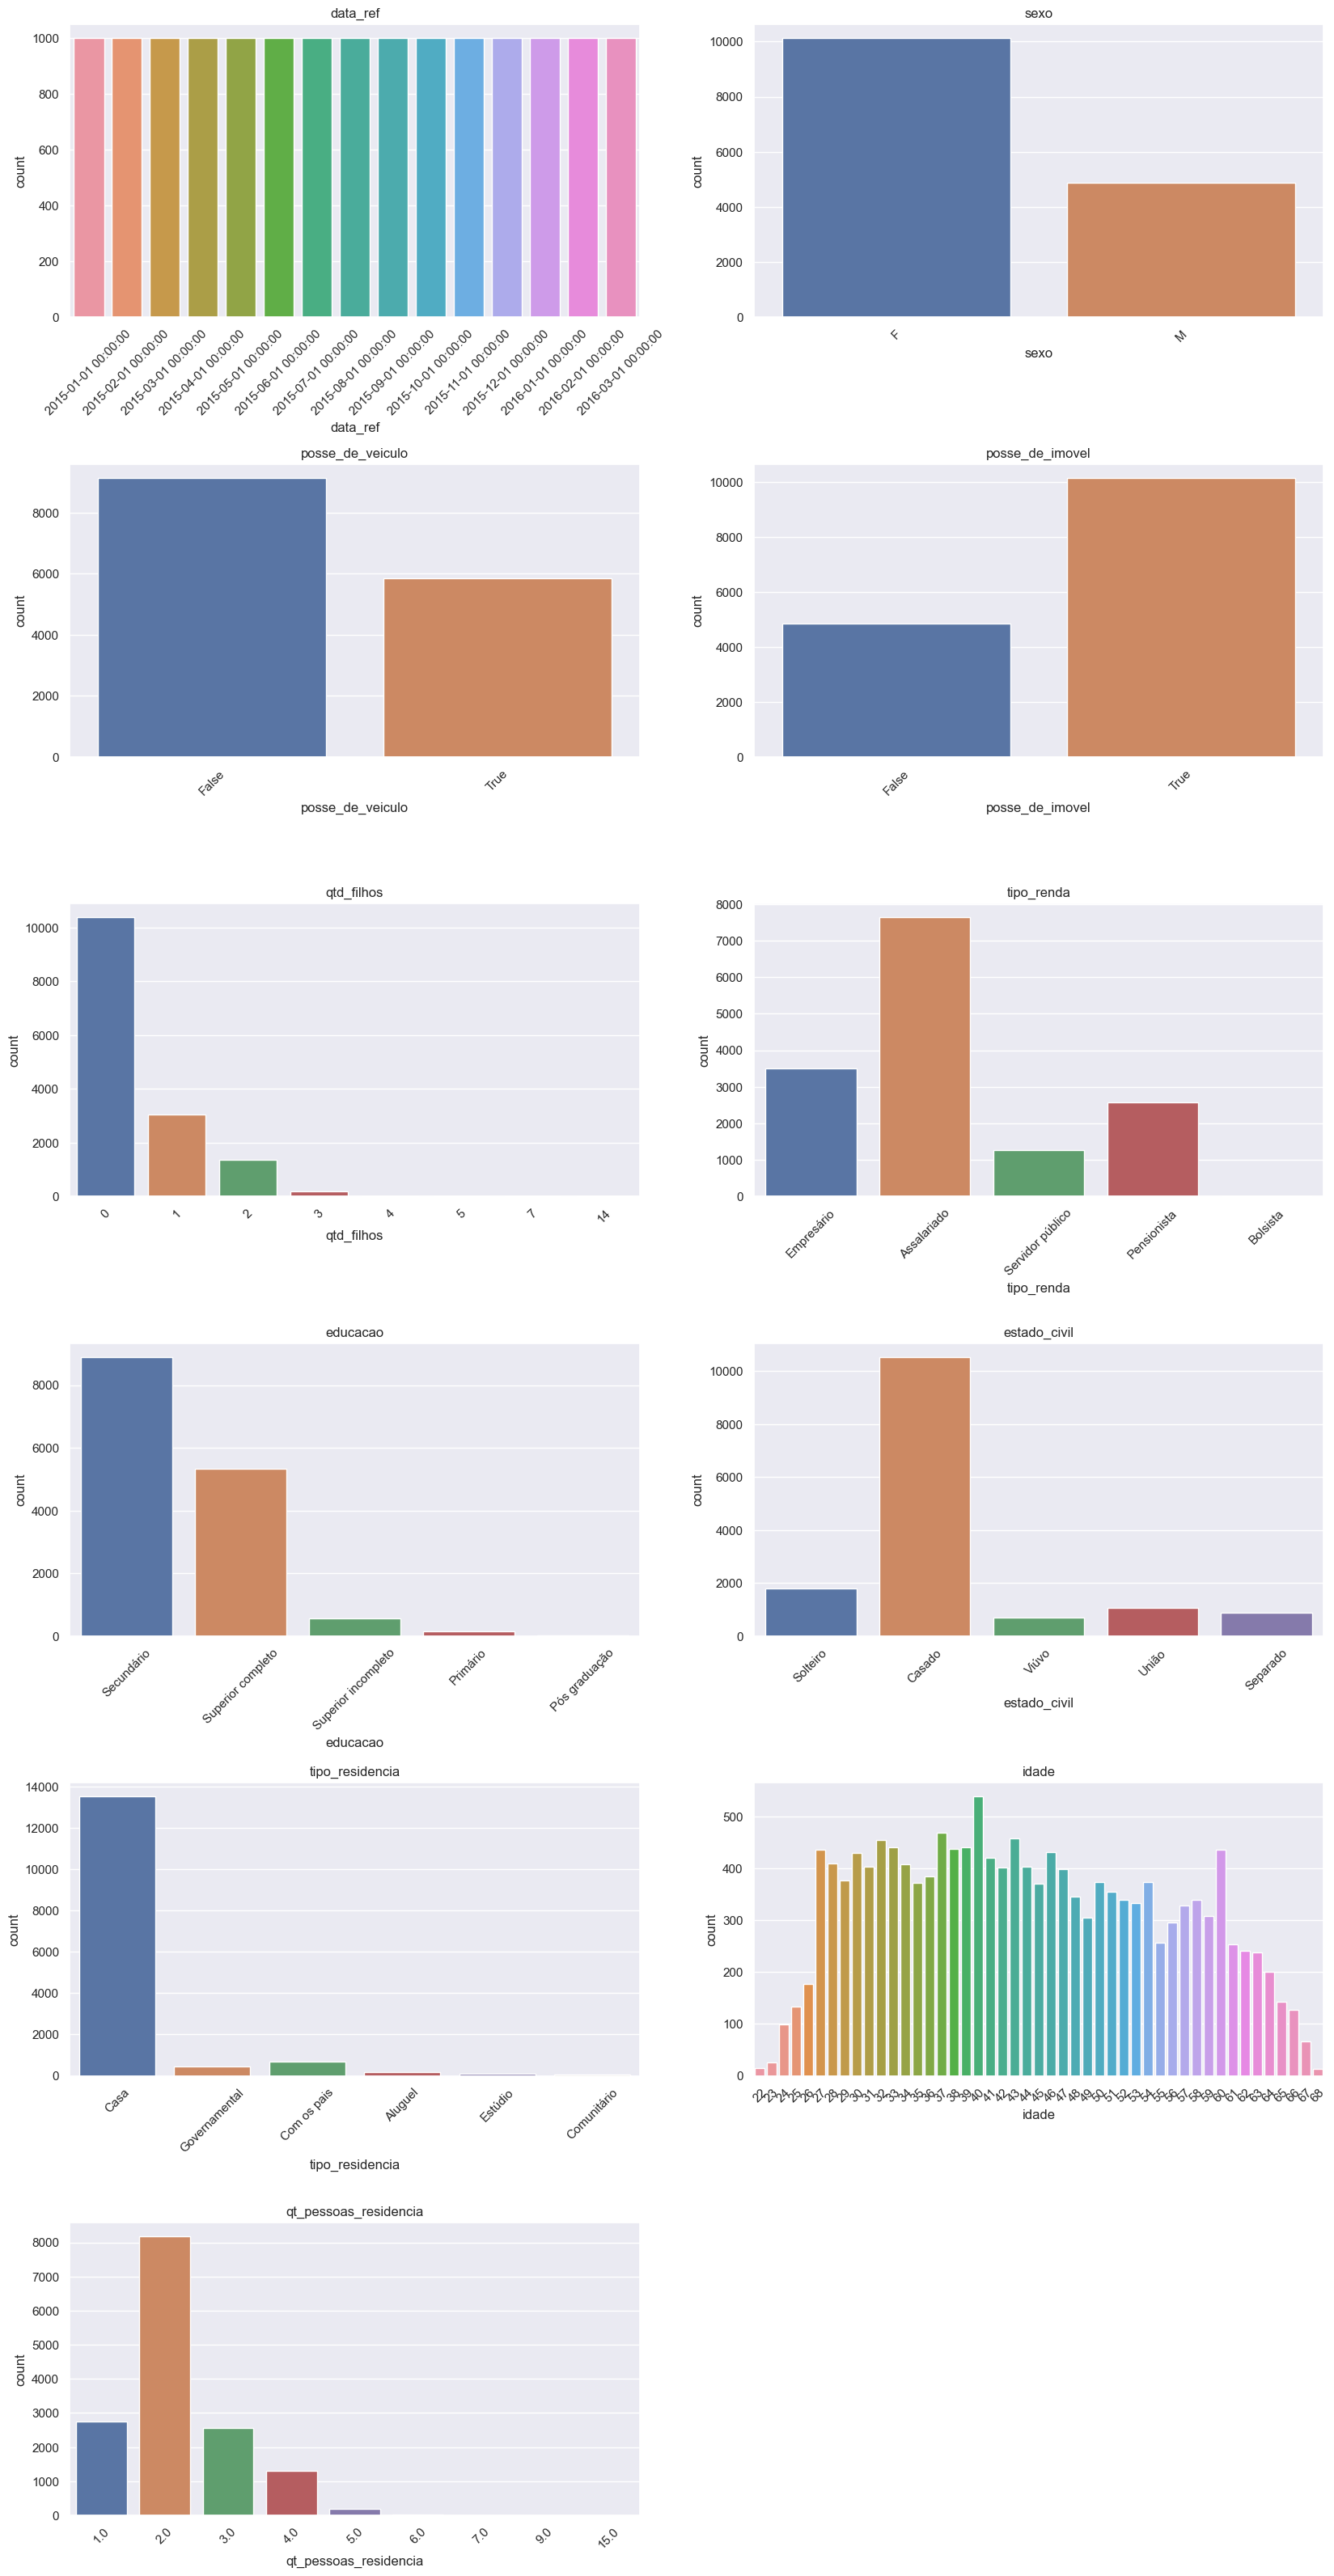

In [8]:
# COUNTPLOT DAS VARIÁVEIS

sns.set_theme()
fig, ax = plt.subplots(nrows=6,
                       ncols=2,
                       figsize=(20,40))

plt.subplots_adjust(hspace=0.5)

renda_grafico.renda_countplot(x='data_ref',data=renda, ax=ax[0,0], title='data_ref')
renda_grafico.renda_countplot(x='sexo',data=renda, ax=ax[0,1], title='sexo')
renda_grafico.renda_countplot(x='posse_de_veiculo',data=renda, ax=ax[1,0], title='posse_de_veiculo')
renda_grafico.renda_countplot(x='posse_de_imovel',data=renda, ax=ax[1,1], title='posse_de_imovel')
renda_grafico.renda_countplot(x='qtd_filhos',data=renda, ax=ax[2,0], title='qtd_filhos')
renda_grafico.renda_countplot(x='tipo_renda',data=renda, ax=ax[2,1], title='tipo_renda')
renda_grafico.renda_countplot(x='educacao',data=renda, ax=ax[3,0], title='educacao')
renda_grafico.renda_countplot(x='estado_civil',data=renda, ax=ax[3,1], title='estado_civil')
renda_grafico.renda_countplot(x='tipo_residencia',data=renda, ax=ax[4,0], title='tipo_residencia')
renda_grafico.renda_countplot(x='idade',data=renda, ax=ax[4,1], title='idade')
renda_grafico.renda_countplot(x='qt_pessoas_residencia',data=renda, ax=ax[5,0], title='qt_pessoas_residencia')
ax[5,1].remove()

<span style="color:red">
<b>COUNTPLOT DAS VARIÁVEIS</b><br>
Observa-se que a maioria dos clientes:<br>
- São mulheres. <br>
- Não possuem veículos. <br>
- Possuem imóvel. <br>
- Não tem filhos. <br>
- São assalariados. <br>
- Tem apenas o Ensino Secundário. <br>
- São casados. <br>
- Moram em casa e com 2 pessoas na residência. <br>
</span>

---

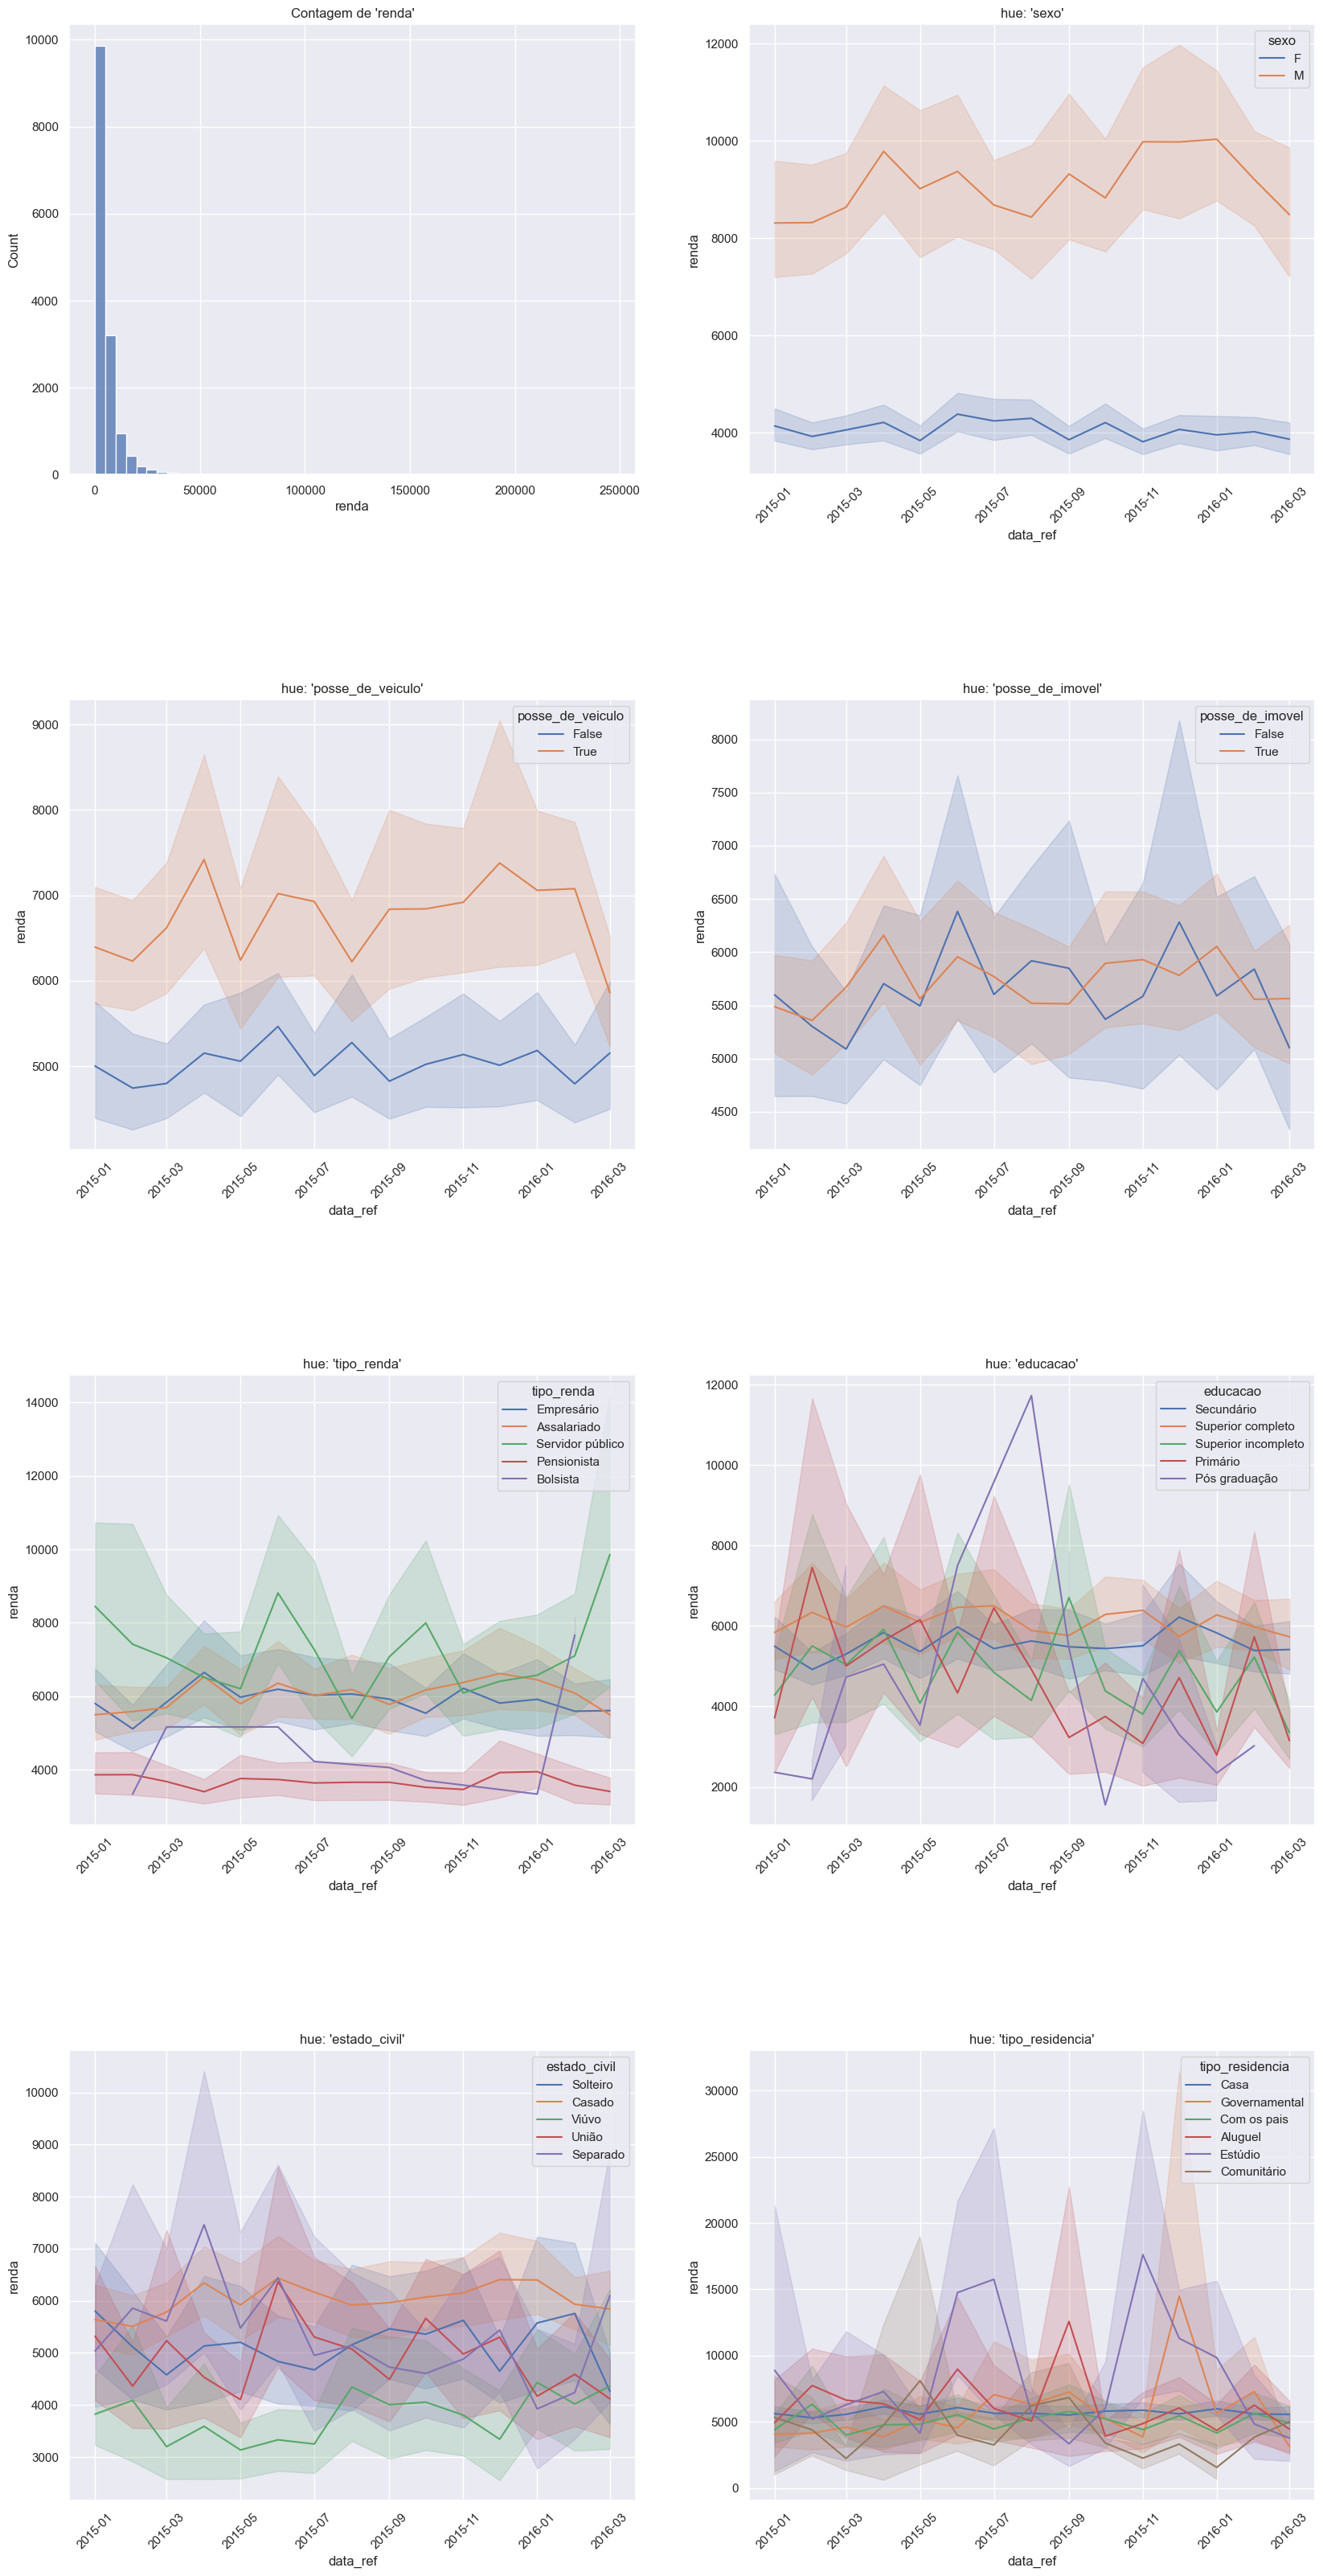

In [9]:
# LINEPLOT 'data_ref' x 'renda' CATEGORIZADAS PELAS VARIÁVEIS

fig, ax = plt.subplots(nrows=4,
                       ncols=2,
                       figsize=(20,40))

plt.subplots_adjust(hspace=0.5)

sns.histplot(x='renda',
             data=renda,
             bins=50, # type: ignore
             ax=ax[0,0]).set_title("Contagem de 'renda'")

renda_grafico.renda_lineplot(x='data_ref',
               y='renda',
               hue='sexo',
               data=renda,
               ax=ax[0,1],
               title="hue: 'sexo'")

renda_grafico.renda_lineplot(x='data_ref',
               y='renda',
               hue='posse_de_veiculo',
               data=renda,
               ax=ax[1,0],
               title="hue: 'posse_de_veiculo'")

renda_grafico.renda_lineplot(x='data_ref',
               y='renda',
               hue='posse_de_imovel',
               data=renda,
               ax=ax[1,1],
               title="hue: 'posse_de_imovel'")

renda_grafico.renda_lineplot(x='data_ref',
               y='renda',
               hue='tipo_renda',
               data=renda,
               ax=ax[2,0],
               title="hue: 'tipo_renda'")

renda_grafico.renda_lineplot(x='data_ref',
               y='renda',
               hue='educacao',
               data=renda,
               ax=ax[2,1],
               title="hue: 'educacao'")

renda_grafico.renda_lineplot(x='data_ref',
               y='renda',
               hue='estado_civil',
               data=renda,
               ax=ax[3,0],
               title="hue: 'estado_civil'")

renda_grafico.renda_lineplot(x='data_ref',
               y='renda',
               hue='tipo_residencia',
               data=renda,
               ax=ax[3,1],
               title="hue: 'tipo_residencia'")

<span style="color:red">
<b>LINEPLOT 'data_ref' x 'renda' CATEGORIZADAS PELAS VARIÁVEIS:</b><br>
Observa-se que a média de clientes:<br>
- Tem mais renda o 'sexo' Masculino. <br>
- Tem mais renda quem possue veículo. <br>
- Tem mais renda os Servidores públicos. <br>
</span>

---

### Entendimento dos dados - Bivariadas




<span style="color:red">BARPLOT DAS VARIÁVEIS COMPARADAS COM 'renda':</span>


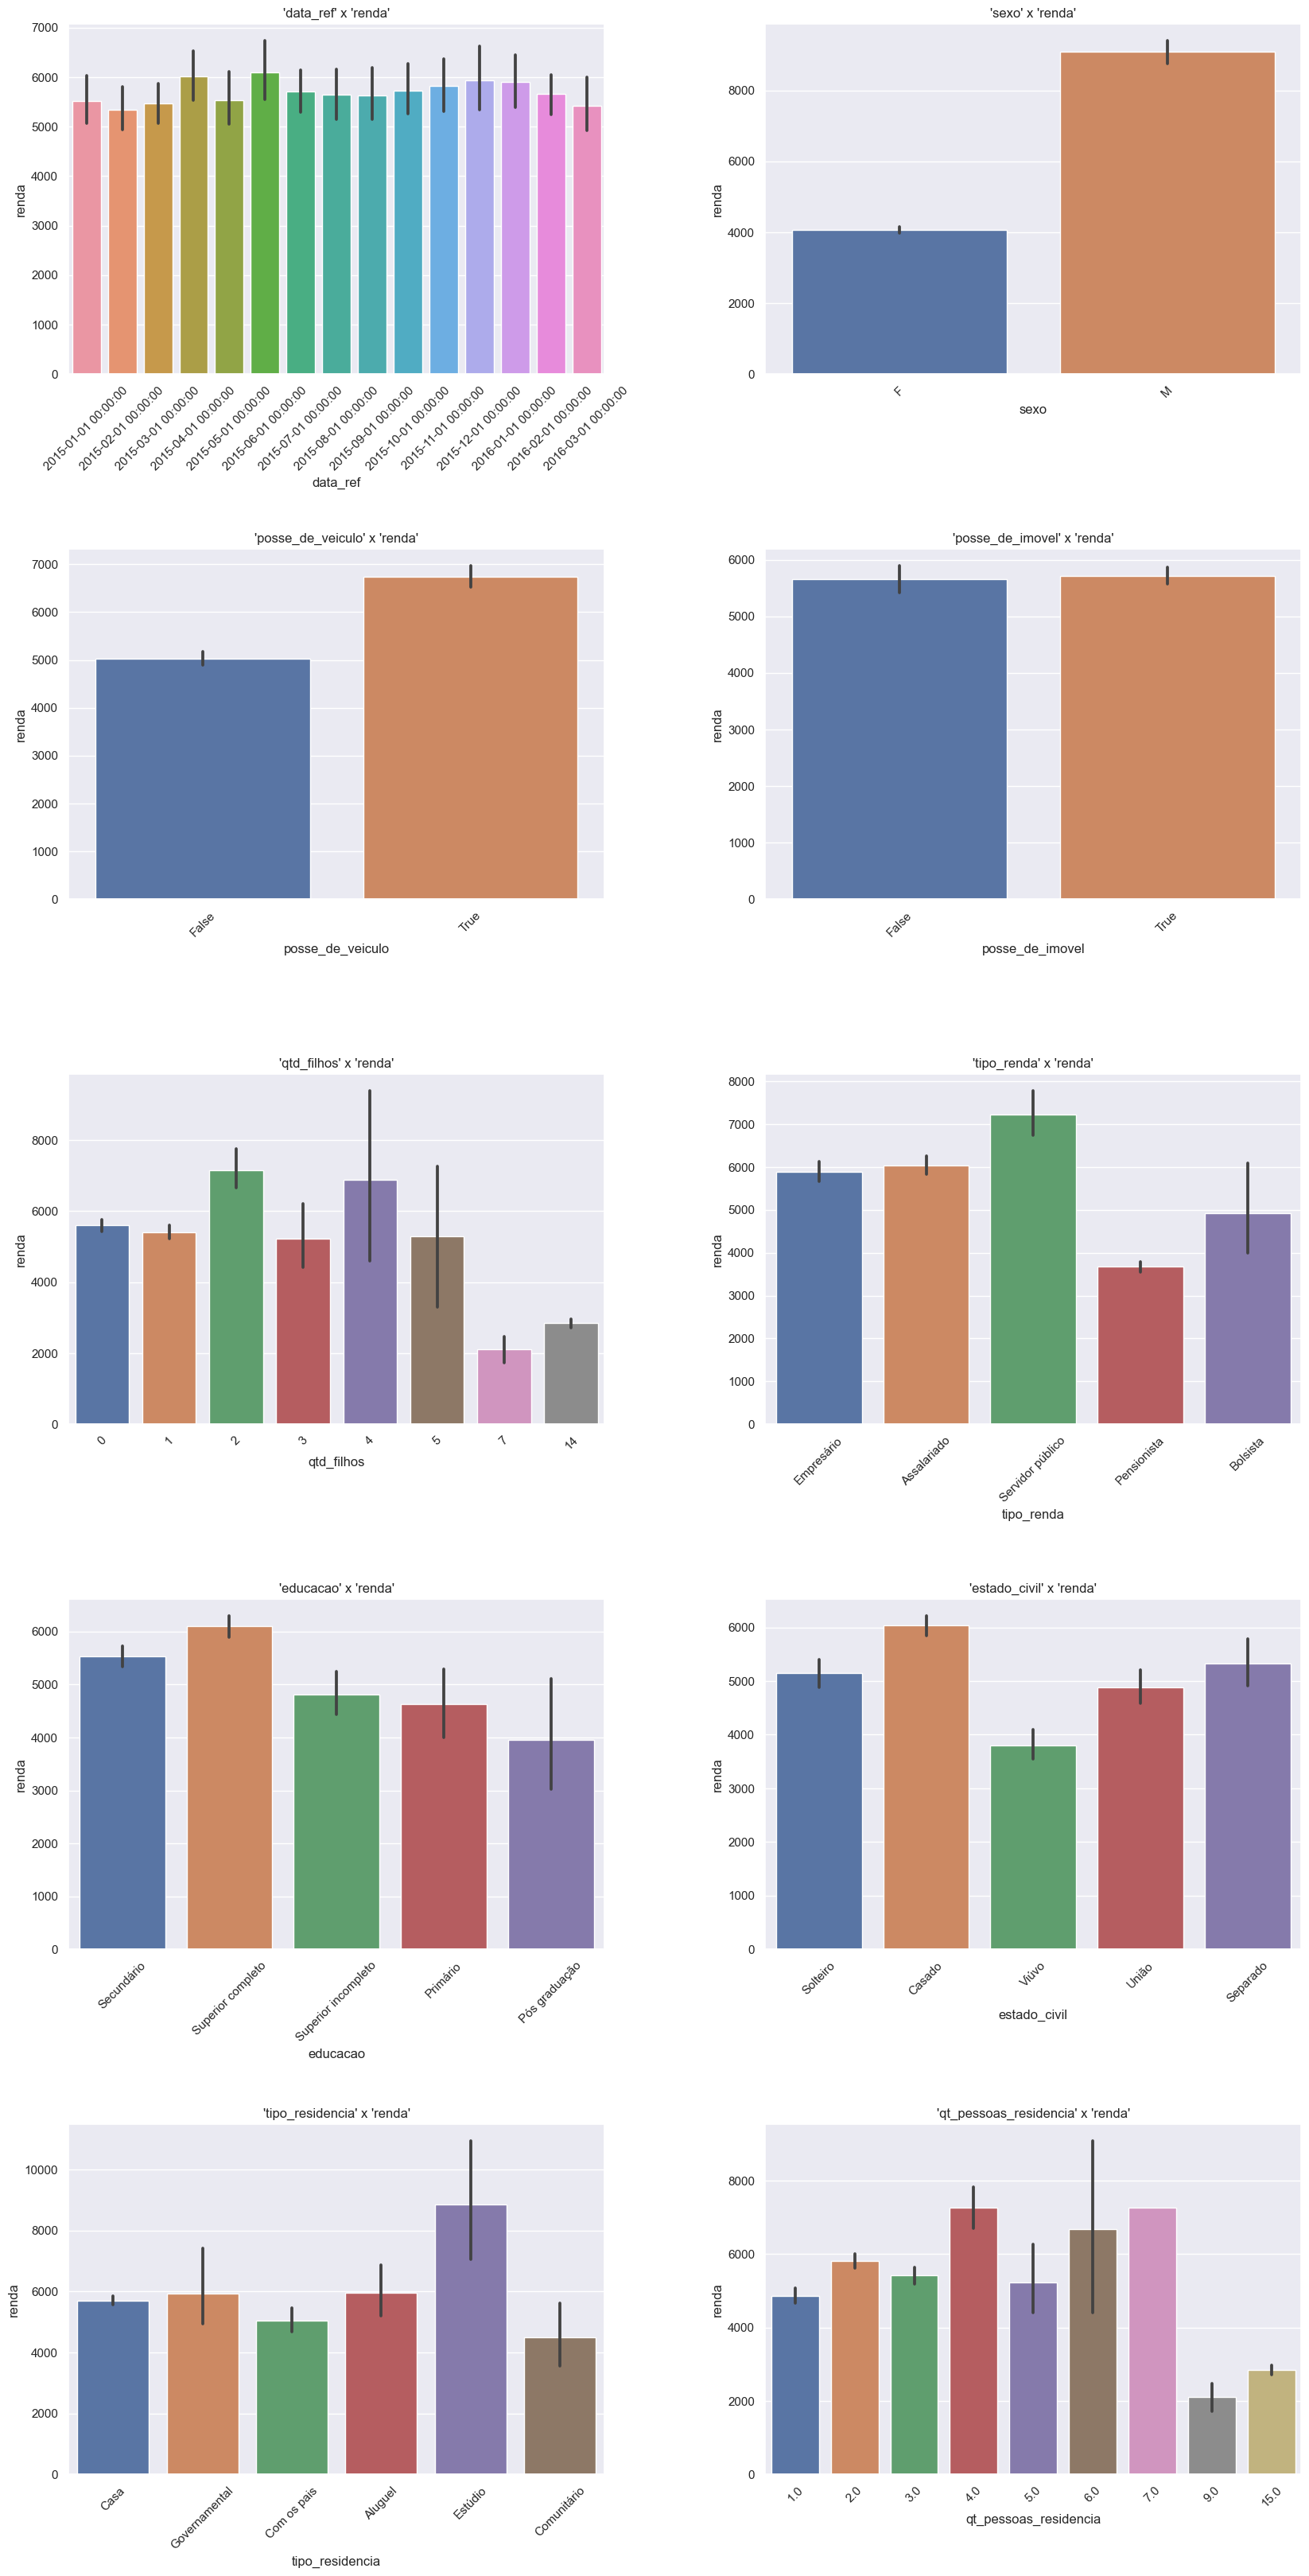

In [10]:
fig, ax = plt.subplots(5,2,figsize=(20,40))
plt.subplots_adjust(hspace=0.5,wspace=0.3)

renda_grafico.renda_barplot(x='data_ref', y='renda', data=renda, ax=ax[0,0], title="'data_ref' x 'renda'")
renda_grafico.renda_barplot(x='sexo', y='renda', data=renda, ax=ax[0,1], title="'sexo' x 'renda'")
renda_grafico.renda_barplot(x='posse_de_veiculo', y='renda', data=renda, ax=ax[1,0], title="'posse_de_veiculo' x 'renda'")
renda_grafico.renda_barplot(x='posse_de_imovel', y='renda', data=renda, ax=ax[1,1], title="'posse_de_imovel' x 'renda'")
renda_grafico.renda_barplot(x='qtd_filhos', y='renda', data=renda, ax=ax[2,0], title="'qtd_filhos' x 'renda'")
renda_grafico.renda_barplot(x='tipo_renda', y='renda', data=renda, ax=ax[2,1], title="'tipo_renda' x 'renda'")
renda_grafico.renda_barplot(x='educacao', y='renda', data=renda, ax=ax[3,0], title="'educacao' x 'renda'")
renda_grafico.renda_barplot(x='estado_civil', y='renda', data=renda, ax=ax[3,1], title="'estado_civil' x 'renda'")
renda_grafico.renda_barplot(x='tipo_residencia', y='renda', data=renda, ax=ax[4,0], title="'tipo_residencia' x 'renda'")
renda_grafico.renda_barplot(x='qt_pessoas_residencia', y='renda', data=renda, ax=ax[4,1], title="'qt_pessoas_residencia' x 'renda'")

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



<span style="color:red">
- Foram retirados os 'id_cliente' que estavam duplicados. De 15000 clientes sobraram 9845 clientes.<br>
- Além disso dropamos a coluna ['Unnamed: 0', 'id_cliente'] por não ter relevância em nossa análise.<br>
- Transformamos a variável 'data_ref' no tipo data e colocamos no index. <br>
- Preenchemos os espaços vazios de 'tempo_emprego' pela mediana do mesmo. Poderiamos também preencher com 0 e deduzir que a pessoa não trabalha.
- Transformamos as varáveis categoricas em flags com o pd.get_dummies().
</span>


In [11]:
# Preparação dos dados.

renda_modelo = (renda.drop_duplicates(subset='id_cliente',
                                             keep='first',
                                             ignore_index=True)
                     .drop(columns=['Unnamed: 0',
                                           'id_cliente'],
                                           axis=1)
                     .set_index(keys='data_ref').copy()
                     .assign(tempo_emprego = lambda x: x['tempo_emprego'].fillna(x['tempo_emprego'].median())))

renda_modelo.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,
2015-01-01,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
2015-01-01,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2015-01-01,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
2015-01-01,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
2015-01-01,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


In [12]:
renda_modelo.dtypes

sexo                      object
posse_de_veiculo            bool
posse_de_imovel             bool
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
dtype: object

In [13]:
renda_modelo = (pd.get_dummies(renda_modelo,
                               columns=['sexo', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'],
                               drop_first=True)
                  .rename(columns={"tipo_renda_Servidor público": "tipo_renda_Servidor_público",
                                   "educacao_Pós graduação": "educacao_Pós_graduação",
                                   "educacao_Superior completo": "educacao_Superior_completo",
                                   "educacao_Superior incompleto": "educacao_Superior_incompleto",
                                   "tipo_residencia_Com os pais": "tipo_residencia_Com_os_pais"
                                   })
                  .astype(float))
renda_modelo.head()

,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_M,tipo_renda_Bolsista,tipo_renda_Empresário,...,educacao_Superior_incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com_os_pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
data_ref,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.0,1.0,0.0,26.0,6.602740,1.0,8060.34,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2015-01-01,1.0,1.0,0.0,28.0,7.183562,2.0,1852.15,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2015-01-01,1.0,1.0,0.0,35.0,0.838356,2.0,2253.89,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2015-01-01,0.0,1.0,1.0,30.0,4.846575,3.0,6600.77,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2015-01-01,1.0,0.0,0.0,33.0,4.293151,1.0,6475.97,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


<span style="color:red">
PRÉ-PODA <br>
- Optamos pela técnica de modelagem DecisionTreeRegressor. Separamos o X e y de treino e de teste. <br>
- Verificamos a melhor profundidade e mínimo de folhas para a nossa árvore de regressão. <br>
- E .
</span>

In [14]:
X = renda_modelo.drop(columns=['renda'], axis=1).copy()
y = renda_modelo['renda'].copy()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)
renda_train, renda_test = train_test_split(renda_modelo, test_size=0.25, random_state=100)

n_minimo,2,3,4,5,6,7,8,9
profundidade,,,,,,,,
2,0.265898,0.265898,0.265898,0.265898,0.265898,0.265898,0.265898,0.265898
3,0.253611,0.253611,0.253611,0.253611,0.253611,0.253611,0.253611,0.253611
4,0.229379,0.229215,0.229215,0.229215,0.229215,0.229215,0.258437,0.258437
5,0.257325,0.306952,0.204050,0.205229,0.205229,0.205229,0.244427,0.245061
6,0.083891,0.316328,0.209581,0.216952,0.217908,0.216496,0.253745,0.256009
7,0.272355,0.301356,0.186941,0.200134,0.198849,0.196553,0.234467,0.229571
8,0.046092,0.291035,0.175449,0.189576,0.190165,0.191096,0.228961,0.226171
9,0.210039,0.242232,0.126600,0.144658,0.145775,0.152966,0.196178,0.207661


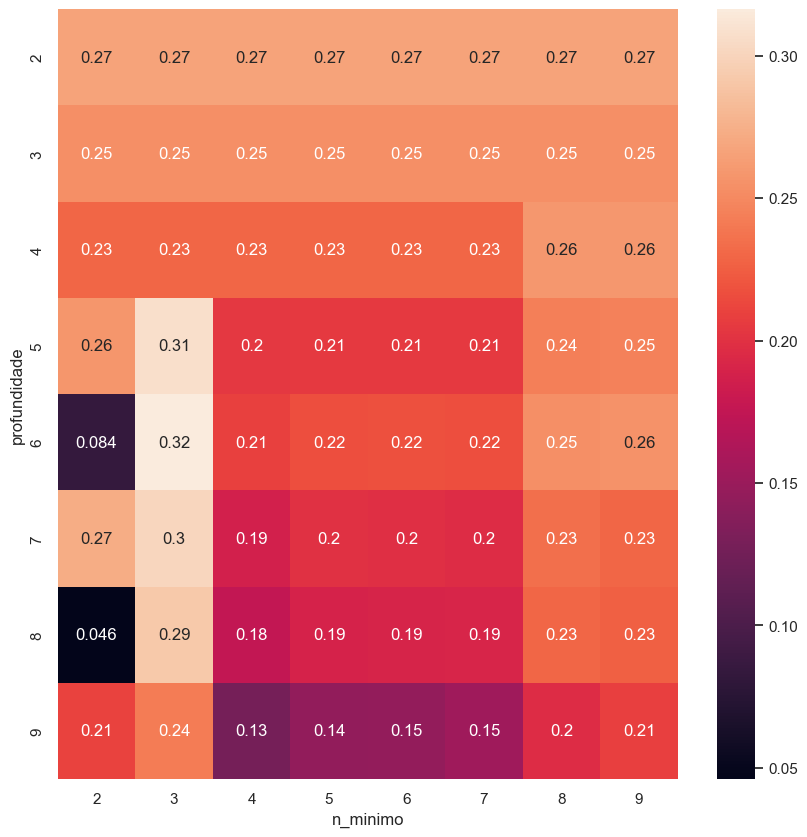

In [16]:
mses = []
ind_i = []
ind_j = []

for i in range(2, 10):
    for j in range(2, 10):
        regr_1 = DecisionTreeRegressor(max_depth=i, min_samples_leaf=j)
        regr_1.fit(X_train, y_train)
        mse1 = regr_1.score(X_test, y_test)
        mses.append(mse1)
        ind_i.append(i)
        ind_j.append(j)
        
df_mse = pd.DataFrame({'mses':mses, 'profundidade':ind_i, 'n_minimo':ind_j})
plt.rc('figure', figsize=(10,10))
sns.heatmap(df_mse.pivot(index='profundidade', columns='n_minimo', values='mses'), annot=True)
df_mse.pivot(index='profundidade', columns='n_minimo', values='mses')

### Rodando o modelo


<span style="color:red">ESCREVER AQUI</span>


In [17]:
reg = DecisionTreeRegressor(max_depth=6, min_samples_leaf=3, random_state=100)
reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=3, random_state=100)

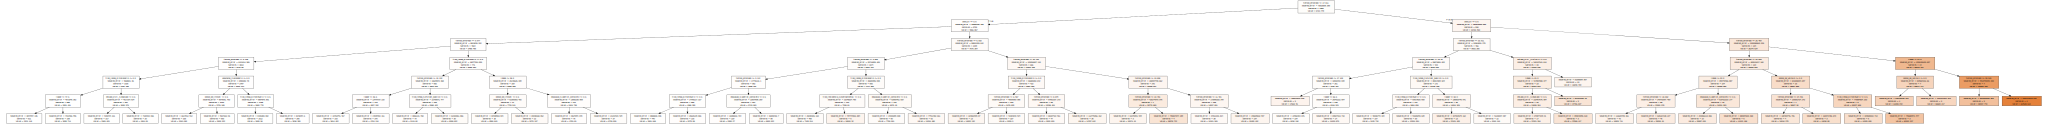

In [18]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(reg,
                                out_file=None, 
                                feature_names=list(X_test.columns),
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [19]:
r_train = reg.score(X_train, y_train)
r_test = reg.score(X_test, y_test)

template = "O R-quadrado da árvore com profundidade {0} é: {1:.2f}"

print(template.format(reg.get_depth(), r_train).replace(".", ",")+" (Treino)")
print(template.format(reg.get_depth(), r_test).replace(".", ",")+" (Teste)")

O R-quadrado da árvore com profundidade 6 é: 0,56 (Treino)
O R-quadrado da árvore com profundidade 6 é: 0,32 (Teste)


In [20]:
y_pred = reg.predict(X_test)
accuracy_score(y_true=y_test, y_pred=y_pred)

ValueError: continuous is not supported

## Etapa 5 Crisp-DM: Avaliação dos resultados


<span style="color:red">ESCREVER AQUI</span>


## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.